In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

import sys
sys.path.append('../')

Jax is using: gpu


# Simulate data

In [3]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 2e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


In [4]:
# define spatial parameters
N = np.array([128, 128]).astype(int) # grid size [grid points]
dx = np.array([element_pitch, element_pitch]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

# define transducer position in domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)

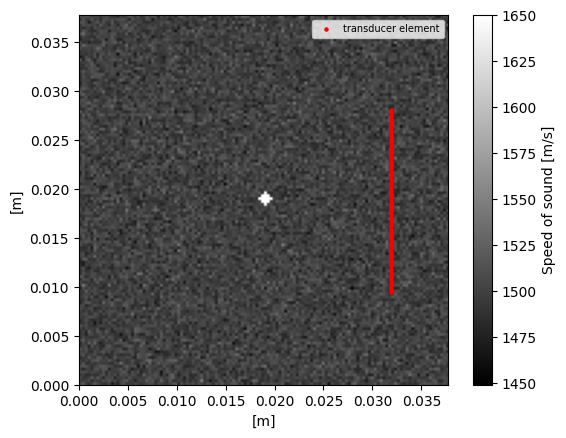

In [5]:
from jwave_utils import get_domain, get_point_medium, get_homogeneous_medium

# define jwave medium
medium_params = {
    'c0': 1500,  # speed of sound [m/s]
    'rho0': 1000,  # density [kg/m^3]
    'background_mean': 1,  # mean of the background noise
    'background_std': 0.008,  # standard deviation of the background noise
    'pml_size': pml[0]  # size of the perfectly matched layer [grid points]
}

domain = get_domain(N, dx)
medium_homogenous = get_homogeneous_medium(domain, **medium_params, background_seed=29)
medium = get_point_medium(domain, **medium_params, scatterer_radius=2, scatterer_contrast=1.1, background_seed=28)

ext = [0, N[0]*dx[0], N[1]*dx[1], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(medium.sound_speed.params, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

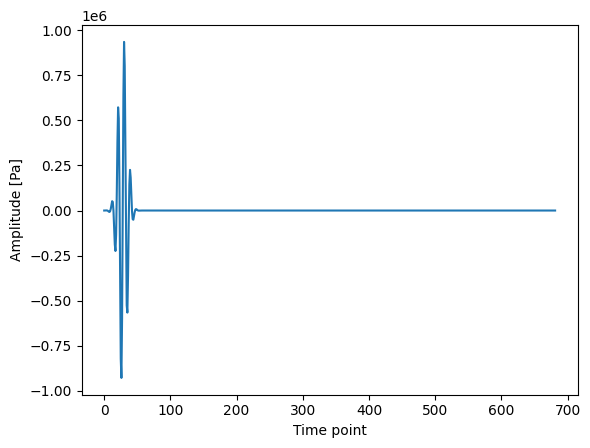

In [12]:
from jwave.geometry import TimeAxis
from jwave_utils import get_plane_wave_excitation

signal_delay = 0
time_axis = TimeAxis.from_medium(medium, cfl=0.3)
sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)

plt.plot(sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [13]:
from jwave_utils import get_data

# simulate data using jwave
pressure, data = get_data(medium, time_axis, sources, element_positions)
_, data_homogenous = get_data(medium_homogenous, time_axis, sources, element_positions)

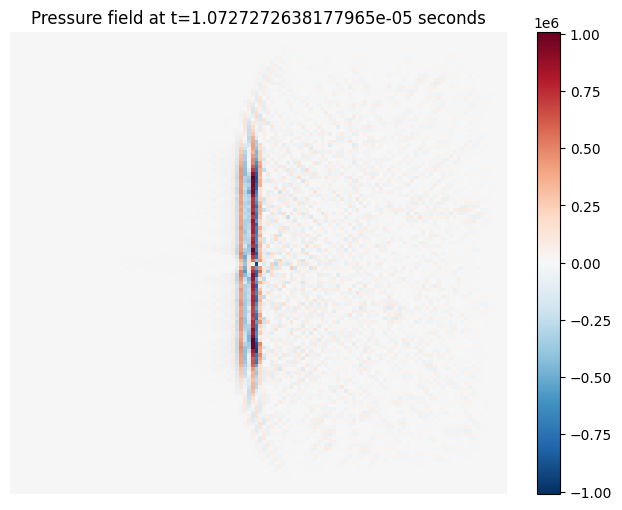

In [14]:
from jwave.utils import show_field

t_idx = 200
show_field(pressure[t_idx])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

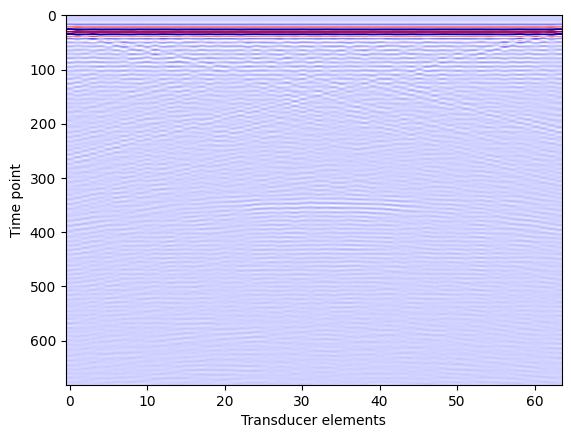

In [15]:
plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

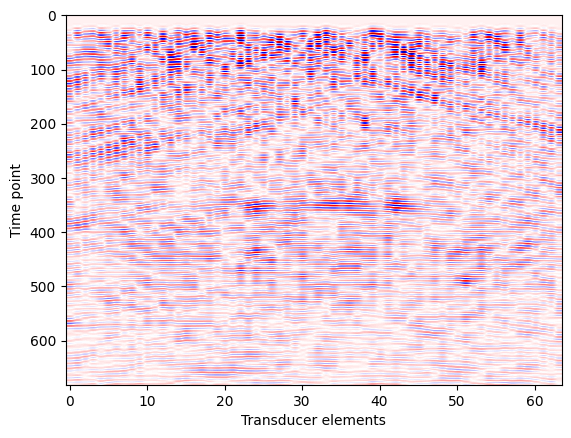

In [16]:
output_data = data-data_homogenous
plt.imshow(output_data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

# Reconstruction

In [21]:
from beamforming_utils import get_receive_beamforming
res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)

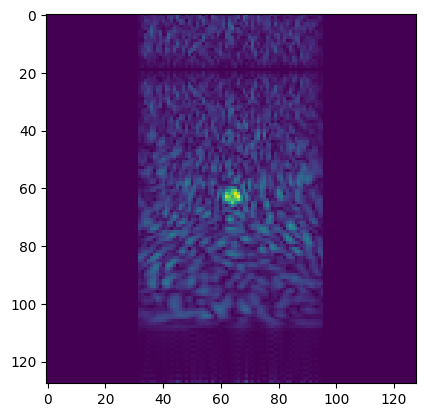

In [25]:
from kwave.utils.filters import gaussian_filter
from kwave.reconstruction.beamform import envelope_detection

def postprocess_result(orig_res):
    result = np.copy(orig_res)
    for i in range(result.shape[0]):
        result[i, :] = gaussian_filter(result[i, :], 1/dx[0], transducer_frequency, 100.0)
    for i in range(result.shape[0]):
        result[i, :] = envelope_detection(result[i, :])
    return np.flipud(result.T)

bmode=postprocess_result(res)
plt.imshow(bmode, cmap='viridis', interpolation='nearest')